In [ ]:
import os
import io
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import torchvision
import pandas as pd

In [ ]:
class EgoHandsDataset(Dataset):
    '''EgoHands dataset'''
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.images_dir = os.path.join(root_dir, 'all_images')
        self.bounding_boxes_file_name = os.path.join(root_dir, 'all_images_bounding_boxes.csv')
        self.bounding_boxes = pd.read_csv(self.bounding_boxes_file_name)
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.images_dir))

    def __getitem__(self, idx):
        '''
        Funzione per ottenere un elemento del dataset

        :param idx: Indice dell'elemento
        :return: Una tupla (immagine, bounding_boxes) dove bounding_boxes è un tensore
        '''
        if torch.is_tensor(idx):
            idx = idx.tolist()

        x = self.bounding_boxes.iloc[idx]
        img_name = os.path.join(self.images_dir, x['image_name'])
        image = cv.imread(img_name)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        image = np.moveaxis(image, 2, 0)
        image = image.astype(np.float32) / 255.0
        image = torch.from_numpy(image)

        if self.transform:
            image = self.transform(image)

        bounding_boxes = torch.zeros((4, 4))
        bounding_boxes[0] = torch.from_numpy(
            x.loc[['box0_x1', 'box0_y1', 'box0_x2', 'box0_y2']].values.astype(np.float32))
        bounding_boxes[1] = torch.from_numpy(
            x.loc[['box1_x1', 'box1_y1', 'box1_x2', 'box1_y2']].values.astype(np.float32))
        bounding_boxes[2] = torch.from_numpy(
            x.loc[['box2_x1', 'box2_y1', 'box2_x2', 'box2_y2']].values.astype(np.float32))
        bounding_boxes[3] = torch.from_numpy(
            x.loc[['box3_x1', 'box3_y1', 'box3_x2', 'box3_y2']].values.astype(np.float32))

        bounding_boxes = bounding_boxes[~torch.isnan(bounding_boxes[:, 0]), :]

        target = {
            'boxes': bounding_boxes,
            'labels': torch.full((bounding_boxes.shape[0],), 1)
        }

        return image, target

    @staticmethod
    def egohands_collate_fn(data):
        tmp = tuple(zip(*data))
        images = tmp[0]
        images = torch.stack(images, dim=0)
        return images, tmp[1]

In [ ]:
egohands_dataset_dir = 'drive/MyDrive/egohands_data/'

In [ ]:
label_mappings = {
    'A': 0,
    'B': 1,
    'C': 2,
    'D': 3,
    'E': 4,
    'F': 5,
    'G': 6
}

class GuitarDataset(Dataset):
    '''Guitar Dataset'''
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.root_dir))

    def __getitem__(self, idx):
        '''
        Funzione per ottenere un elemento del dataset

        :param idx: Indice dell'elemento
        :return: Una tupla (immagine, label)
        '''
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, os.listdir(self.root_dir)[idx])
        image = cv.imread(img_name)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        image = np.moveaxis(image, 2, 0)
        image = image.astype(np.float32) / 255.0
        image = torch.from_numpy(image)

        img_base_name = os.path.basename(img_name)
        label = label_mappings.get(img_base_name.split(' ')[0])

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
guitar_dataset_dir = 'drive/MyDrive/guitar_dataset/all_images/'

In [ ]:
# montare Google Drive. Si può fare dall'interfaccia grafica del sito

In [ ]:
egohands_dataset = EgoHandsDataset(egohands_dataset_dir)

In [ ]:
from torchvision import transforms
transform = transforms.Compose([
        transforms.Resize((540, 959))
])
guitar_dataset = GuitarDataset(guitar_dataset_dir, transform=transform)

# Rete addestrata per un'epoca

In [ ]:
root_dir_saves = 'drive/MyDrive/salvataggi_pytorch/trained_one_epoch/'

In [ ]:
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(num_classes=2)
model.load_state_dict(torch.load(root_dir_saves + 'model_state_dict', map_location=torch.device('cpu')))
model.eval()

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


  0%|          | 0.00/21.1M [00:00<?, ?B/s]

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): ConvBNActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): ConvBNActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): Identity()
          )
        )
      )
      (2): InvertedResidual(


In [ ]:
# prendiamo un'immagine del dataset egohands
image, target = egohands_dataset[100]

In [ ]:
out = model(image.unsqueeze(0))
out

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[{'boxes': tensor([[525.2534, 281.1365, 667.3117, 374.8783],
          [586.3532, 510.7572, 898.2603, 720.0000],
          [403.3140, 290.9175, 523.3277, 389.6889],
          [222.6519, 636.2885, 339.8521, 720.0000],
          [228.2520, 632.3851, 439.4672, 720.0000],
          [408.0541, 286.8265, 684.8145, 384.7978],
          [191.0944, 649.8818, 502.5581, 704.3844],
          [382.1990, 689.2255, 505.3351, 717.6340],
          [370.6897, 680.6501, 505.7422, 702.9426],
          [421.0818, 695.1538, 497.9072, 716.5781],
          [299.1046, 682.2186, 514.0116, 718.6888],
          [230.5855, 664.5021, 324.6436, 690.0400],
          [563.8275, 639.0294, 724.4024, 718.5205],
          [528.1470, 290.9657, 667.0360, 332.7228],
          [274.6094, 614.0702, 350.1902, 720.0000],
          [412.8331, 684.7202, 557.1569, 719.4893],
          [439.2920, 689.2926, 483.2166, 717.9252],
          [664.2616, 190.8641, 795.5062, 297.9833],
          [419.8037, 690.3638, 465.7404, 717.9828],
   

In [ ]:
# decidiamo una soglia: conserviamo le bounding box
# che hanno uno score superiore alla soglia
score_threshold = 0.95

In [ ]:
def get_final_boxes(out, score_threshold):
  final_boxes = None
  boxes = out[0]['boxes']
  scores = out[0]['scores']
  for box, score in zip(boxes, scores):
    if score > score_threshold:
      if final_boxes is None:
        final_boxes = torch.clone(box).reshape(1, 4)
      else:
        final_boxes = torch.cat((final_boxes, box.reshape(1, 4)))
  return final_boxes

In [ ]:
final_boxes = get_final_boxes(out, score_threshold)
print(final_boxes)

tensor([[525.2534, 281.1365, 667.3117, 374.8783],
        [586.3532, 510.7572, 898.2603, 720.0000],
        [403.3140, 290.9175, 523.3277, 389.6889],
        [222.6519, 636.2885, 339.8521, 720.0000]], grad_fn=<CatBackward>)


In [ ]:
im = np.moveaxis(image.numpy(), 0, 2)

In [ ]:
im = im.copy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


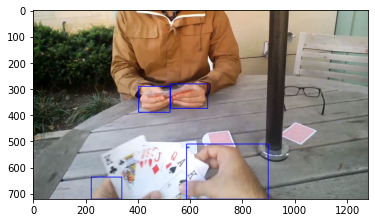

In [ ]:
for box in final_boxes:
  box = box.detach().numpy().astype(int)
  cv.rectangle(im, (box[0], box[1]), (box[2], box[3]), (0, 0, 255), 2)
plt.imshow(im)
plt.show()

In [ ]:
# prendiamo un'immagine del guitar dataset
image, label = guitar_dataset[100]

In [ ]:
out = model(image.unsqueeze(0))
out

[{'boxes': tensor([[329.4540, 136.4795, 472.7304, 279.3367],
          [672.0275, 128.8529, 766.6119, 241.5729],
          [531.2768, 211.9208, 706.2905, 286.6505],
          [655.7004, 141.0442, 739.4547, 261.6295],
          [ 72.9353,   0.0000, 313.4850, 122.8169]], grad_fn=<StackBackward>),
  'labels': tensor([1, 1, 1, 1, 1]),
  'scores': tensor([0.9540, 0.8511, 0.3648, 0.1853, 0.0817], grad_fn=<IndexBackward>)}]

In [ ]:
# decidiamo una soglia: conserviamo le bounding box
# che hanno uno score superiore alla soglia
score_threshold = 0.8

In [ ]:
final_boxes = get_final_boxes(out, score_threshold)
print(final_boxes)

tensor([[329.4540, 136.4795, 472.7304, 279.3367],
        [672.0275, 128.8529, 766.6119, 241.5729]], grad_fn=<CatBackward>)


In [ ]:
im = np.moveaxis(image.numpy(), 0, 2)

In [ ]:
# non so perché se non faccio la copy(), cv.rectangle() non disegna i rettangoli :(
im = im.copy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


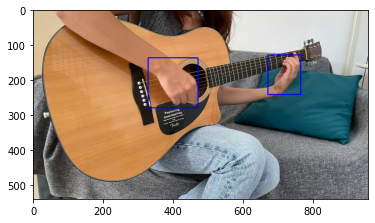

In [ ]:
for box in final_boxes:
  box = box.detach().numpy().astype(int)
  cv.rectangle(im, (box[0], box[1]), (box[2], box[3]), (0, 0, 255), 2)
plt.imshow(im)
plt.show()

In [ ]:
# prendiamo un'altra immagine del guitar dataset
image, label = guitar_dataset[300]

In [ ]:
out = model(image.unsqueeze(0))
out

[{'boxes': tensor([[252.9795, 239.3745, 383.2900, 349.5685],
          [687.0480, 223.4173, 788.8465, 320.4165],
          [553.2674, 101.7042, 690.9363, 238.5778],
          [719.3109, 214.7653, 804.7534, 245.6792],
          [695.2486, 214.9544, 801.0764, 282.1323]], grad_fn=<StackBackward>),
  'labels': tensor([1, 1, 1, 1, 1]),
  'scores': tensor([0.9857, 0.9631, 0.3711, 0.0569, 0.0517], grad_fn=<IndexBackward>)}]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[252 239 383 349]
[687 223 788 320]


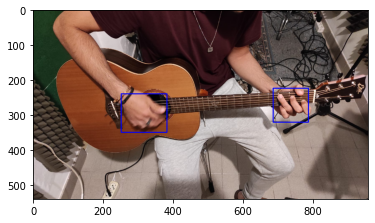

In [ ]:
final_boxes = get_final_boxes(out, score_threshold)

im = np.moveaxis(image.numpy(), 0, 2)
im = im.copy()

for box in final_boxes:
  box = box.detach().numpy().astype(int)
  print(box)
  cv.rectangle(im, (box[0], box[1]), (box[2], box[3]), (0, 0, 255), 2)
plt.imshow(im)
plt.show()

# Rete addestrata per due epoche

In [ ]:
root_dir_saves = 'drive/MyDrive/salvataggi_pytorch/trained_two_epochs/'

In [ ]:
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(num_classes=2)
model.load_state_dict(torch.load(root_dir_saves + 'model_state_dict', map_location=torch.device('cpu')))
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): ConvBNActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): ConvBNActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): Identity()
          )
        )
      )
      (2): InvertedResidual(


In [ ]:
# prendiamo un'immagine del dataset egohands
image, target = egohands_dataset[100]

In [ ]:
out = model(image.unsqueeze(0))
out

[{'boxes': tensor([[569.7930, 512.1306, 919.8671, 720.0000],
          [532.0098, 281.9244, 659.9402, 371.5330],
          [411.5840, 291.3079, 519.8896, 385.4385],
          [224.0643, 639.9707, 334.3003, 720.0000],
          [223.1948, 651.6543, 502.8704, 711.3589],
          [391.3471, 690.1554, 505.3009, 716.8937],
          [410.0316, 286.5211, 656.3400, 381.1284],
          [237.3963, 675.8373, 512.5336, 718.6553],
          [420.5241, 698.0845, 496.8661, 717.2137],
          [228.5307, 668.6392, 323.5741, 690.7832],
          [307.7294,   7.3067, 520.3823, 187.6289],
          [671.2979, 194.5326, 789.5336, 303.3098],
          [414.8638, 324.7094, 514.5248, 356.8123]], grad_fn=<StackBackward>),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
  'scores': tensor([0.9990, 0.9976, 0.9975, 0.9804, 0.9430, 0.2685, 0.1873, 0.1616, 0.1062,
          0.1048, 0.0594, 0.0588, 0.0559], grad_fn=<IndexBackward>)}]

In [ ]:
# decidiamo una soglia: conserviamo le bounding box
# che hanno uno score superiore alla soglia
score_threshold = 0.95

In [ ]:
final_boxes = get_final_boxes(out, score_threshold)
print(final_boxes)

tensor([[569.7930, 512.1306, 919.8671, 720.0000],
        [532.0098, 281.9244, 659.9402, 371.5330],
        [411.5840, 291.3079, 519.8896, 385.4385],
        [224.0643, 639.9707, 334.3003, 720.0000]], grad_fn=<CatBackward>)


In [ ]:
im = np.moveaxis(image.numpy(), 0, 2)

In [ ]:
im = im.copy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


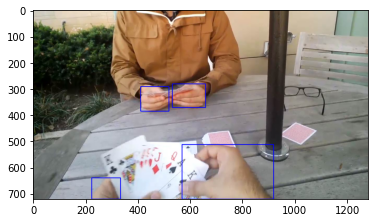

In [ ]:
for box in final_boxes:
  box = box.detach().numpy().astype(int)
  cv.rectangle(im, (box[0], box[1]), (box[2], box[3]), (0, 0, 255), 2)
plt.imshow(im)
plt.show()

In [ ]:
# prendiamo un immagine del guitar dataset
image, label = guitar_dataset[100]

In [ ]:
out = model(image.unsqueeze(0))
out

[{'boxes': tensor([[336.2472, 137.0797, 474.4174, 275.9448],
          [670.7542, 129.7481, 761.4672, 245.7895],
          [541.0801, 205.9690, 710.3978, 291.0153],
          [ 60.1604,   0.0000, 310.5473, 124.3122],
          [ 37.3218, 112.6018, 405.1514, 367.0569],
          [615.5686, 139.1023, 761.9595, 274.2692],
          [643.5278, 157.3530, 756.2423, 229.8819]], grad_fn=<StackBackward>),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1]),
  'scores': tensor([0.9719, 0.8371, 0.4106, 0.1638, 0.0659, 0.0567, 0.0549],
         grad_fn=<IndexBackward>)}]

In [ ]:
# decidiamo una soglia: conserviamo le bounding box
# che hanno uno score superiore alla soglia
score_threshold = 0.8

In [ ]:
final_boxes = None
boxes = out[0]['boxes']
scores = out[0]['scores']
for idx, (box, score) in enumerate(zip(boxes, scores)):
  if score > score_threshold:
    if final_boxes is None:
      final_boxes = torch.clone(box).reshape(1, 4)
    else:
      final_boxes = torch.cat((final_boxes, box.reshape(1, 4)))

In [ ]:
im = np.moveaxis(image.numpy(), 0, 2)

In [ ]:
im = im.copy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


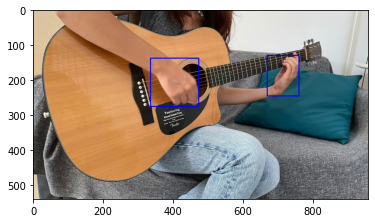

In [ ]:
for box in final_boxes:
  box = box.detach().numpy().astype(int)
  cv.rectangle(im, (box[0], box[1]), (box[2], box[3]), (0, 0, 255), 2)
plt.imshow(im)
plt.show()

In [ ]:
# prendiamo un'altra immagine del guitar dataset
image, label = guitar_dataset[300]

In [ ]:
out = model(image.unsqueeze(0))
out

[{'boxes': tensor([[259.0166, 234.9427, 385.6541, 348.9496],
          [693.5733, 224.1561, 790.6113, 316.6070],
          [556.4754, 108.6491, 699.9351, 236.8233],
          [ 80.8435, 190.1859, 257.3796, 399.9931]], grad_fn=<StackBackward>),
  'labels': tensor([1, 1, 1, 1]),
  'scores': tensor([0.9958, 0.9833, 0.3432, 0.0711], grad_fn=<IndexBackward>)}]

In [ ]:
final_boxes = get_final_boxes(out, score_threshold)
print(final_boxes)

tensor([[259.0166, 234.9427, 385.6541, 348.9496],
        [693.5733, 224.1561, 790.6113, 316.6070]], grad_fn=<CatBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[259 234 385 348]
[693 224 790 316]


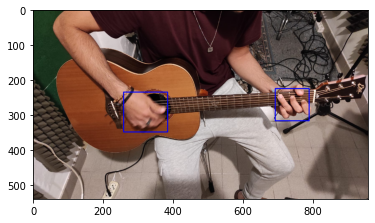

In [ ]:
im = np.moveaxis(image.numpy(), 0, 2)
im = im.copy()

for box in final_boxes:
  box = box.detach().numpy().astype(int)
  print(box)
  cv.rectangle(im, (box[0], box[1]), (box[2], box[3]), (0, 0, 255), 2)
plt.imshow(im)
plt.show()